In [1]:
from eda_function import *

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings('ignore')

dataPath = "../data/"
parquetPath = dataPath + "parquet_files/"
parquetTrain = parquetPath + "train/"
parquetTest = parquetPath + "test/"

In [2]:
description = pd.read_csv(dataPath + 'feature_definitions.csv')

In [3]:
base = pd.read_parquet(parquetTrain + 'train_base.parquet')

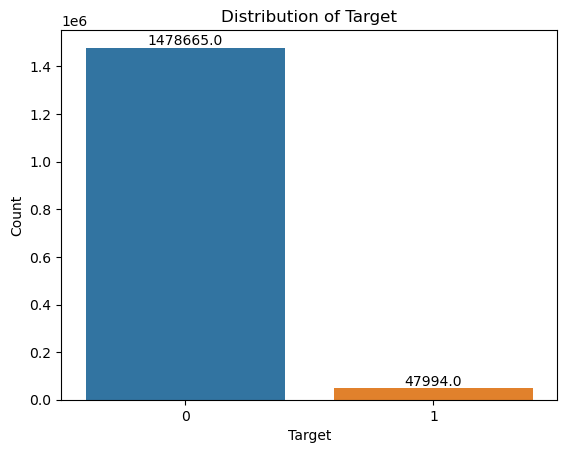

In [4]:
ax = sns.countplot(x = 'target', data=base)

plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='center', 
                xytext=(0,5), 
                textcoords='offset points'
    )

plt.show()


- `unbalanced` target

In [5]:
static = pd.concat(
    [
        pd.read_parquet(parquetTrain + 'train_static_0_0.parquet'),
        pd.read_parquet(parquetTrain + 'train_static_0_1.parquet'),        
    ],
    axis=0
)
static.reset_index(drop=True, inplace=True)

In [6]:
static.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Columns: 168 entries, case_id to validfrom_1069D
dtypes: bool(1), float64(128), int64(1), object(38)
memory usage: 1.9+ GB


In [7]:
base = reduce_mem_usage(base)

Memory usage of dataframe is 58.24 MB
Memory usage after optimization is: 26.21 MB
Decreased by 55.0%


In [8]:
static = reduce_mem_usage(static)

Memory usage of dataframe is 1946.59 MB
Memory usage after optimization is: 840.44 MB
Decreased by 56.8%


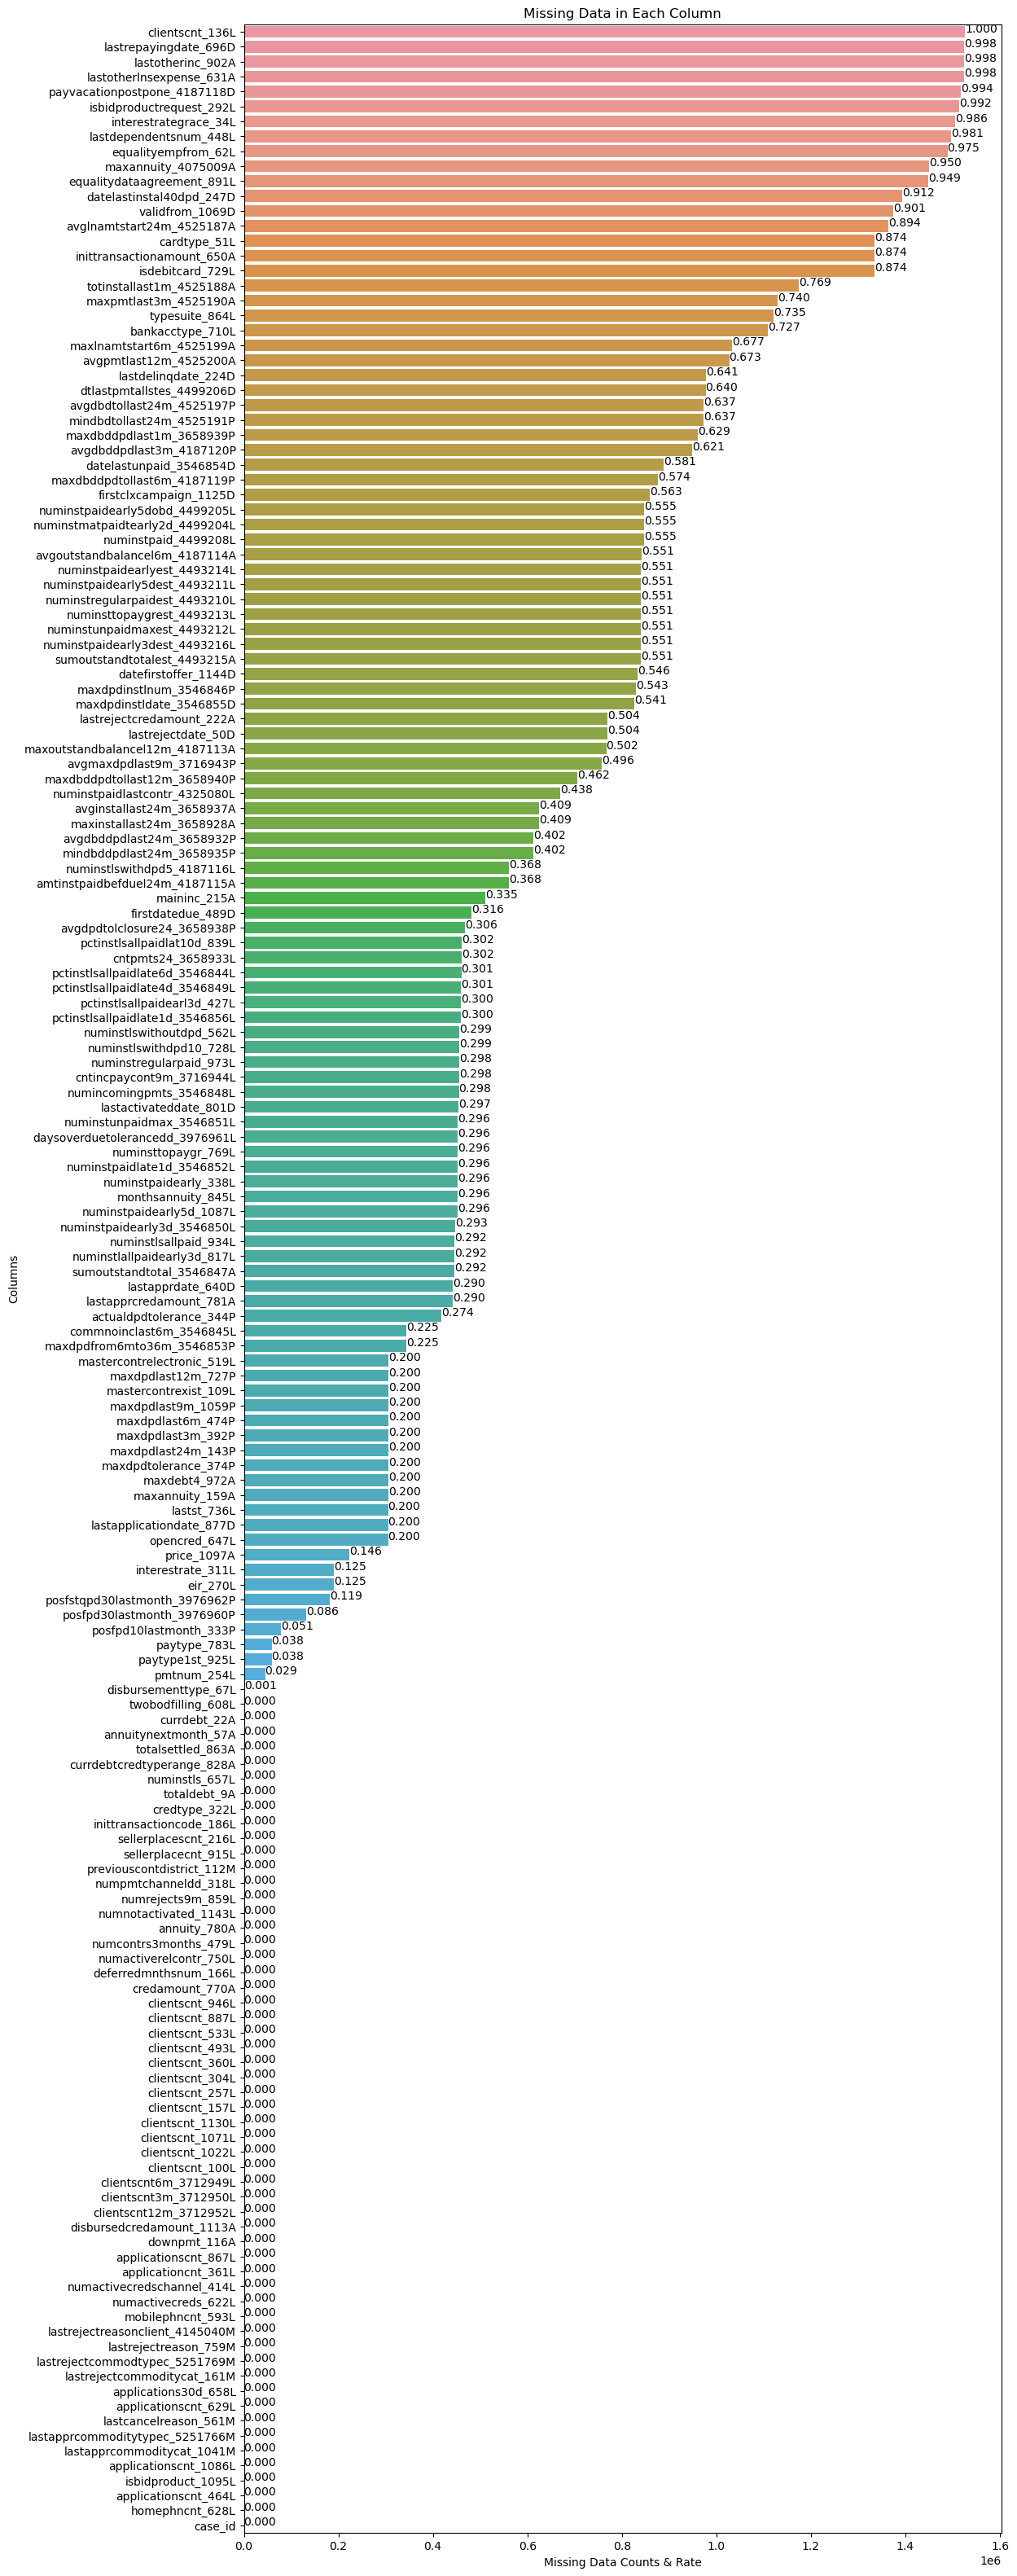

In [9]:
# 결측치 개수 및 비율 계산
missing_counts = static.isna().sum()
missing_counts = missing_counts.sort_values(ascending=False)
missing_rates = missing_counts / len(static)

plt.figure(figsize=(12, 40))
sns.barplot(x=missing_counts, y=missing_counts.index)

plt.xlabel('Missing Data Counts & Rate')
plt.ylabel('Columns')
plt.title('Missing Data in Each Column')

for index, value in enumerate(missing_counts):
    plt.text(value, index, f'{missing_rates[index]:.3f}')




In [10]:
df = base.merge(static, how='left', on='case_id')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Columns: 172 entries, case_id to validfrom_1069D
dtypes: category(38), datetime64[ns](1), float32(129), int32(2), int8(2)
memory usage: 860.8 MB


`Sustained stability over time`
- stability in the future is critical, as a sudden drop in performance means that loans will be issued to worse clients on average.
- A gini score is calculated for predictions corresponding to each WEEK_NUM

In [11]:
def aggregated_plot(agg_col, plotting_col, title=None):
    df_ = df.groupby(agg_col)[plotting_col].mean()
    ax = sns.lineplot(data=df_)
    plt.tight_layout()
    if title:
        ax.set_title(title)
    plt.show()

`Numerical type`

In [12]:
numerical_cols = [col for col in df.columns if ((df[col].dtype == 'float32') and (df[col].isna().sum() / len(df) < 0.8))]
len(numerical_cols)

121

amtinstpaidbefduel24m_4187115A: Number of instalments paid before due date in the last 24 months. 



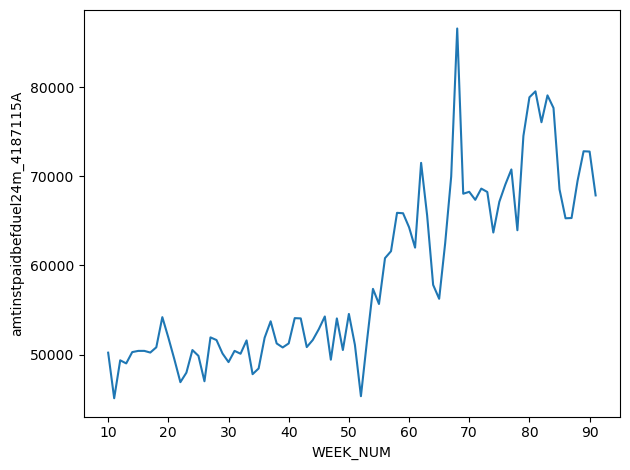





annuity_780A: Monthly annuity amount. 



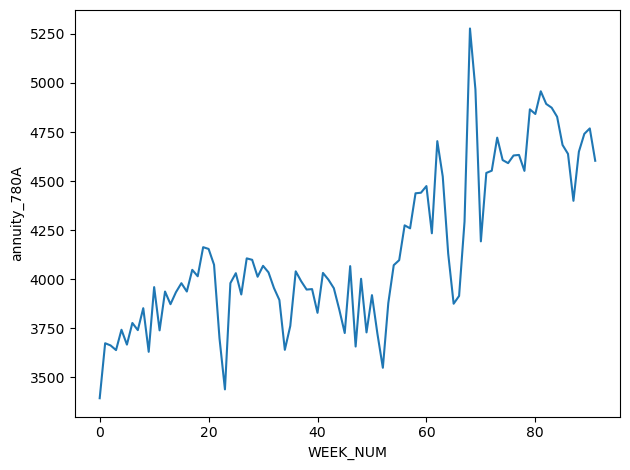





annuitynextmonth_57A: Next month's amount of annuity. 



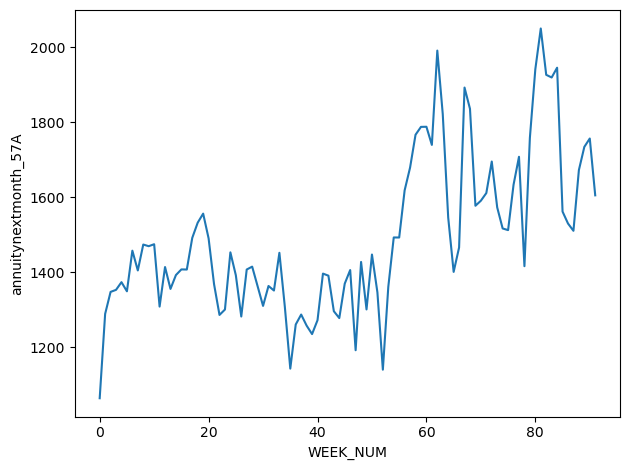





applicationcnt_361L: Number of applications associated with the same email address as the client. 



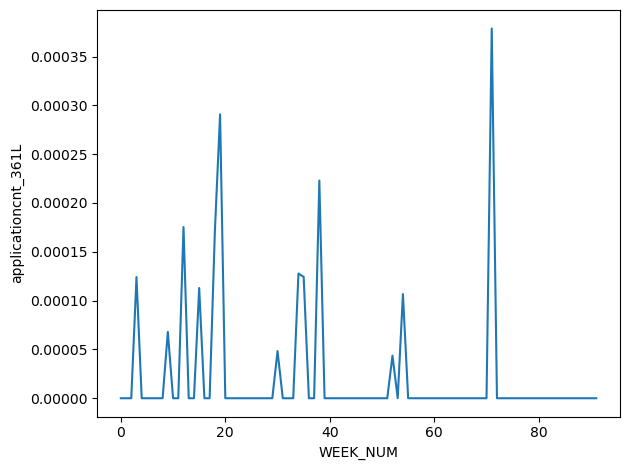





applications30d_658L: Number of applications made by the client in the last 30 days. 



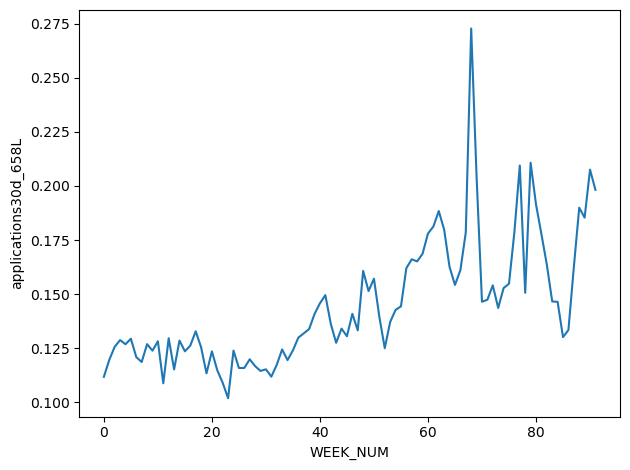





applicationscnt_1086L: Number of applications associated with the same phone number. 



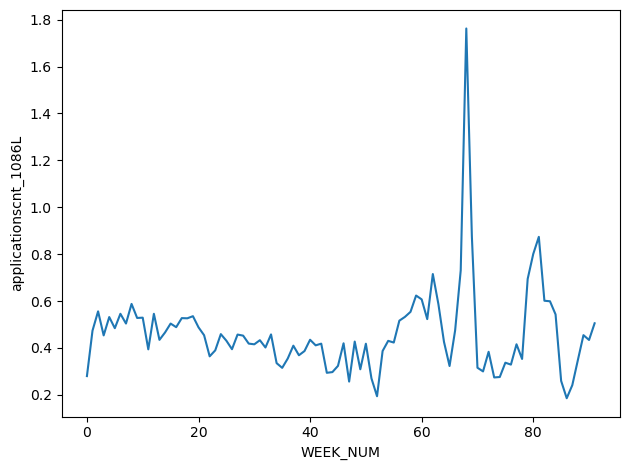





applicationscnt_464L: Number of applications made in the last 30 days by other clients with the same employer as the applicant. 



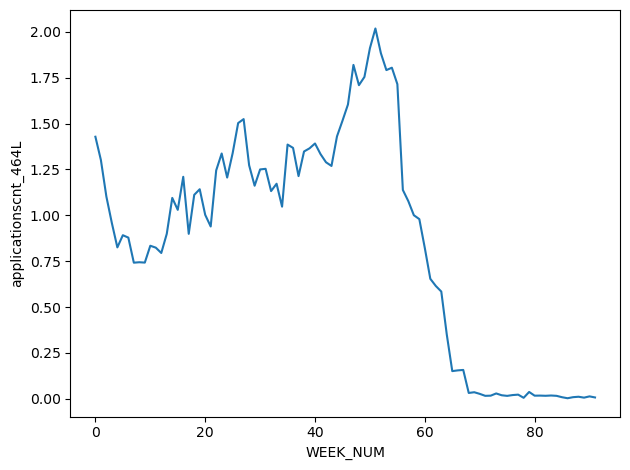





applicationscnt_629L: Number of applications with the same employer in the last 7 days. 



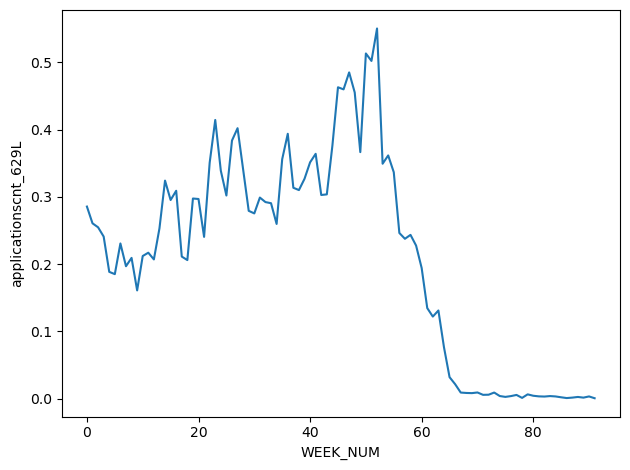

In [13]:
for col in numerical_cols[1:9]:
    feature_description = description.loc[description['Variable'] == col, 'Description'].values[0]
    print(f'{col}: {feature_description} \n')
    aggregated_plot('WEEK_NUM', col)
    print('\n\n\n')

`Categorical type`

In [14]:
category_under_5_cols = [col for col in df.columns if ((df[col].dtype == 'category') and (df[col].nunique() <= 5))]
high_cardinality_cols = [col for col in df.columns if ((df[col].dtype == 'category') and (col not in category_under_5_cols))]

In [15]:
print(len(category_under_5_cols), len(high_cardinality_cols))

14 24


In [25]:
def truncate_title(title, max_length=80):
    if len(title) > max_length:
        return title[:max_length - 3] + "..."
    else:
        return title
def categories_target_count(feature, title):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    f.suptitle(truncate_title(title), fontsize=16, ha='left', x=0.125)
    
    sns.countplot(x = feature, data=df, hue='target', ax=ax1)
    ax1.set_title('Count of target')
    
    sns.barplot(x=feature, y='target' ,data=df, ax=ax2, palette='Set2')
    ax2.set_title('Probability of target "1"')
    
    plt.show()

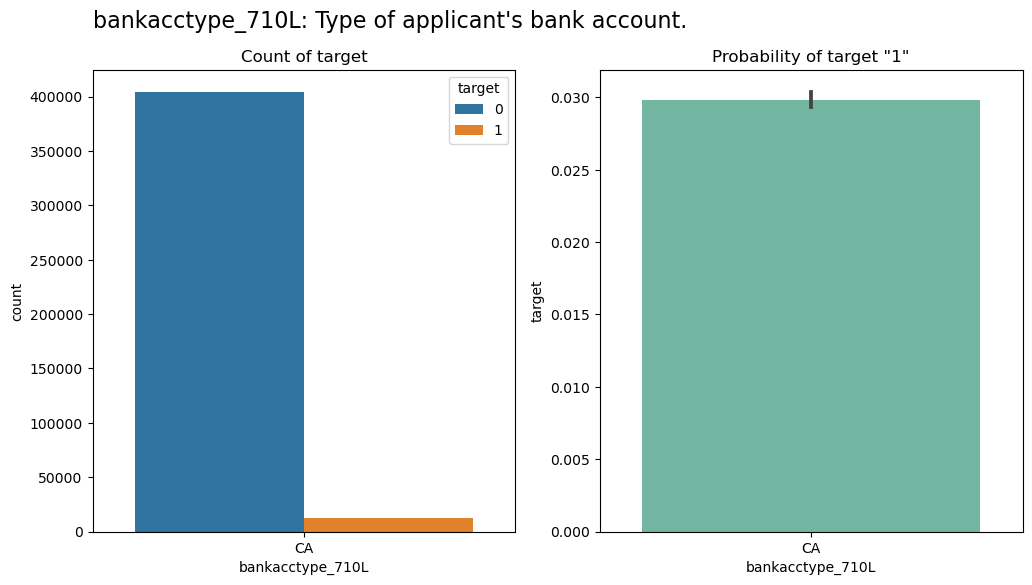

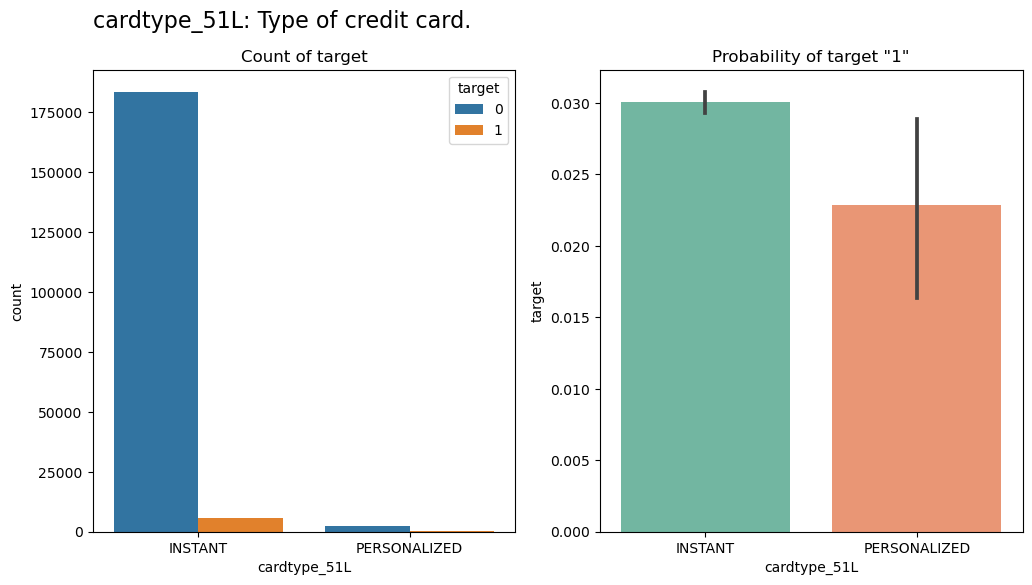

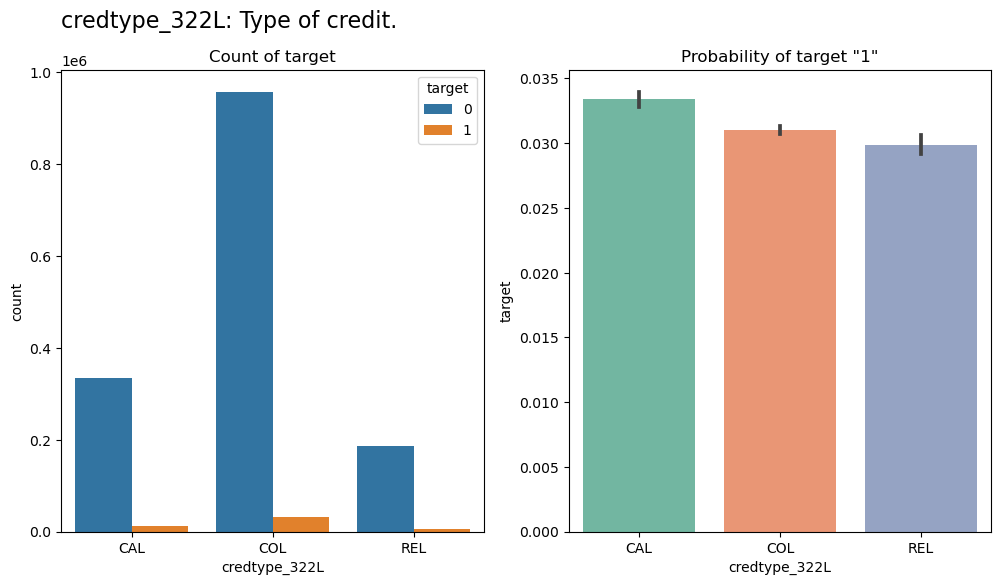

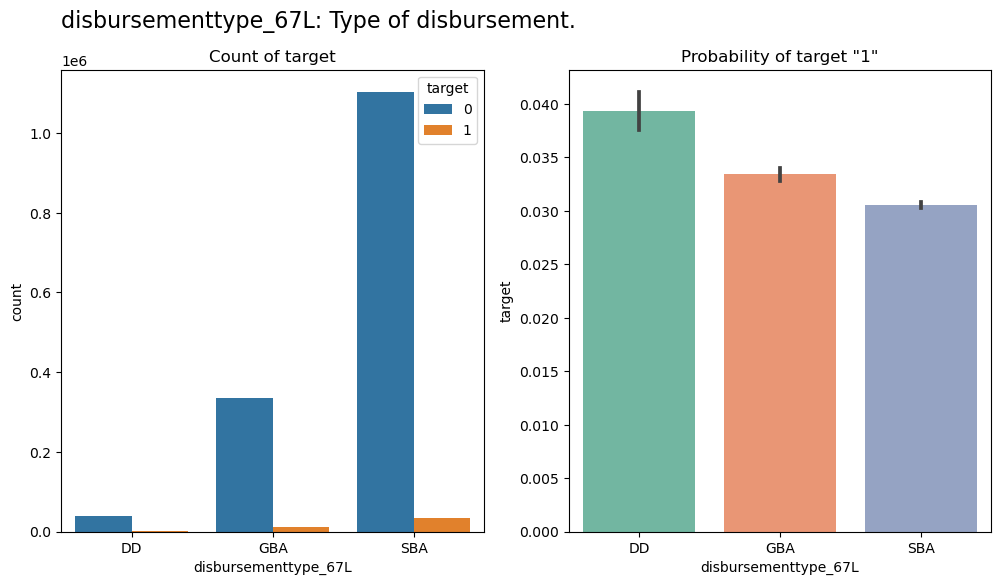

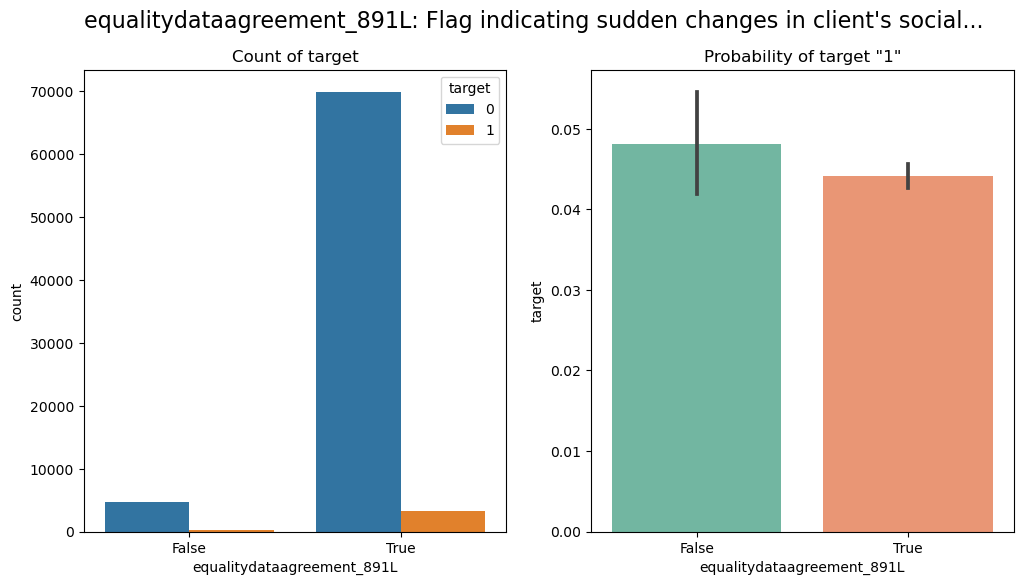

In [17]:
for col in category_under_5_cols[:5]:
    feature_description = description.loc[description['Variable'] == col, 'Description'].values[0]
    categories_target_count(col, 
                        f'{col}: {feature_description}')

In [27]:
def categories_target_count(feature, title):
    f, ax = plt.subplots(1,1,figsize = (8,4))
    sns.countplot(x = feature, data = df, hue='target')
    plt.grid(color = "black", linestyle = "-.", linewidth = 0.5, axis="y", which = "major")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='right')  # Rotate x-axis labels by 45 degrees
    ax.set_title(f"{title}")
    # Adjust the position of the legend to the right and a bit higher
    plt.legend(loc='upper right', bbox_to_anchor=(1.31, 1))
    plt.show()

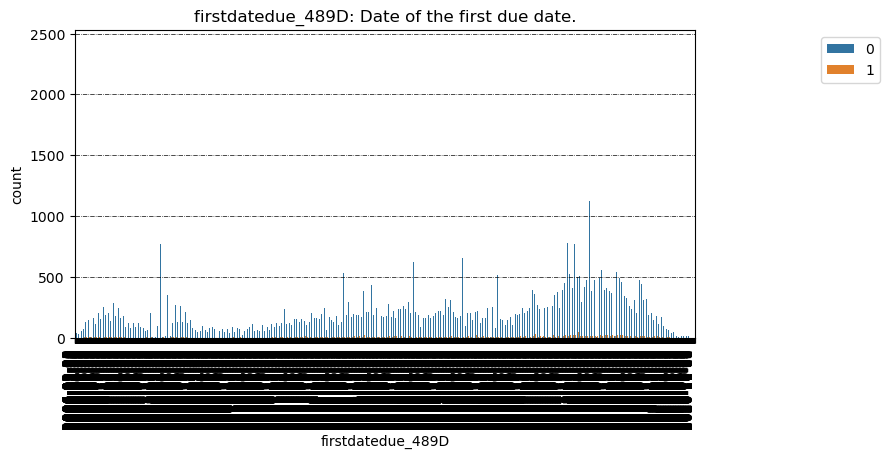

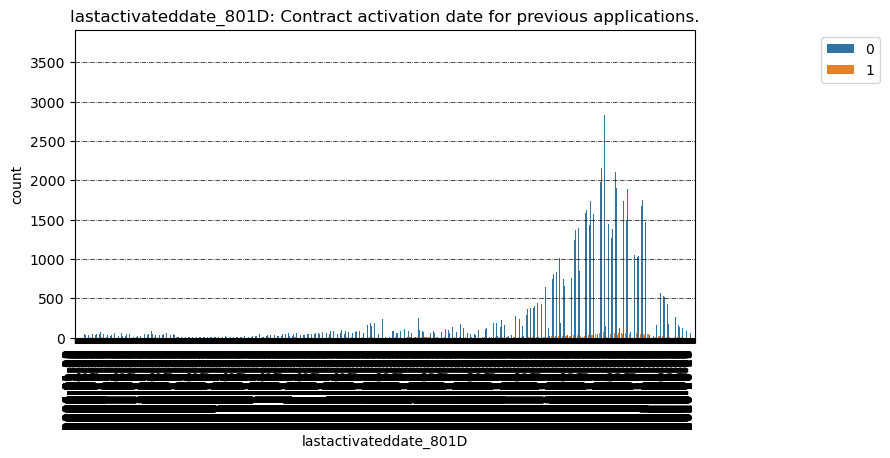

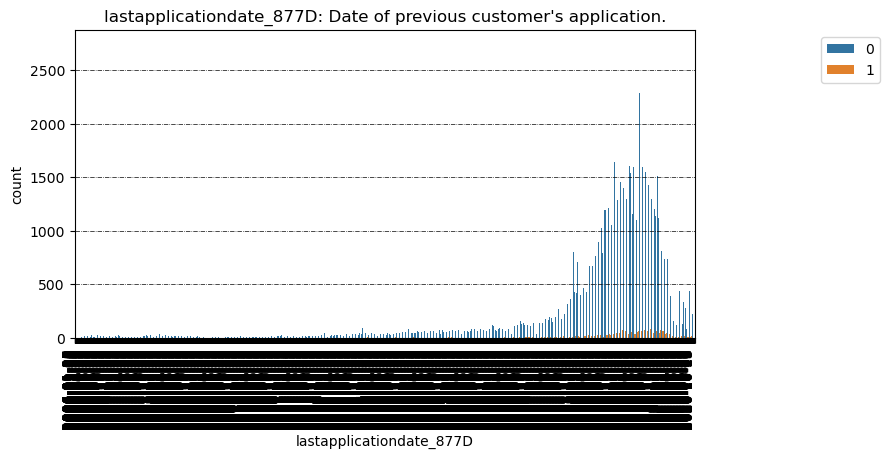

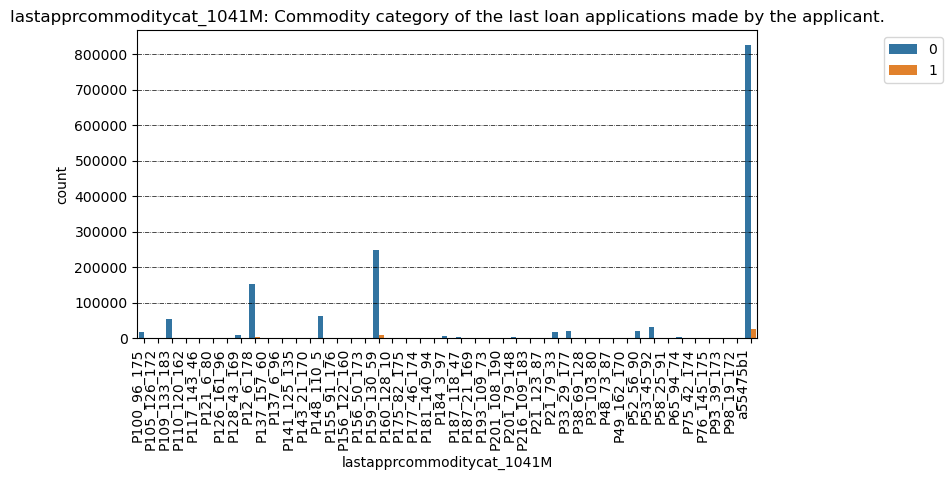

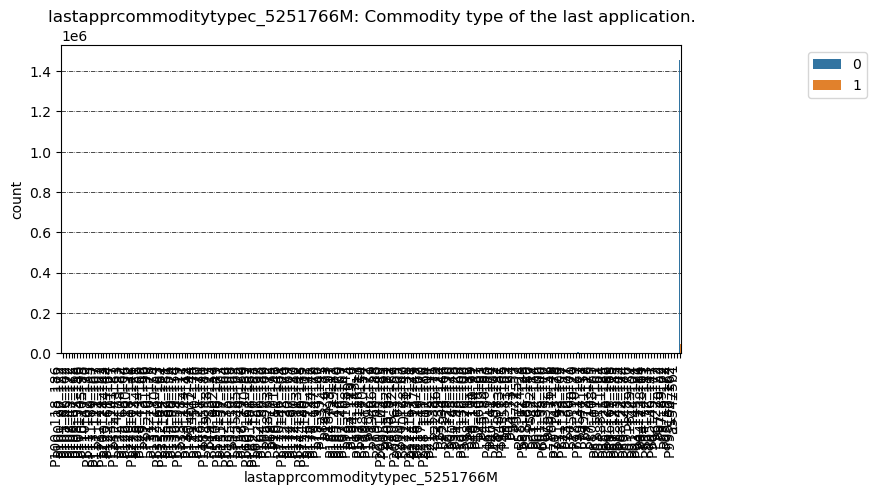

In [29]:
for col in high_cardinality_cols[5:10]:
    feature_description = description.loc[description['Variable'] == col, 'Description'].values[0]
    categories_target_count(col, 
                        f'{col}: {feature_description}')